<a href="https://colab.research.google.com/github/aminrabinia/Privacy-Policy-vs.-Regulations/blob/master/DeepLearning_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# SNLI dataset 90MB
!wget --no-check-certificate https://nlp.stanford.edu/projects/snli/snli_1.0.zip -O /tmp/snli_dataset.zip

--2019-12-11 14:36:58--  https://nlp.stanford.edu/projects/snli/snli_1.0.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94550081 (90M) [application/zip]
Saving to: ‘/tmp/snli_dataset.zip’

/tmp/snli_dataset.z 100%[===================>]  90.17M  14.6MB/s    in 18s     

2019-12-11 14:37:16 (5.02 MB/s) - ‘/tmp/snli_dataset.zip’ saved [94550081/94550081]



In [0]:
import os
import zipfile

local_zip = '/tmp/snli_dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

train_file = '/tmp/snli_1.0/snli_1.0_train.jsonl'
valid_file = '/tmp/snli_1.0/snli_1.0_dev.jsonl'
test_file = '/tmp/snli_1.0/snli_1.0_test.jsonl'

In [0]:
# MultiNLI dataset 216 MB
!wget --no-check-certificate https://www.nyu.edu/projects/bowman/multinli/multinli_1.0.zip -O /tmp/multinli_dataset.zip

In [0]:
import os
import zipfile

local_zip = '/tmp/multinli_dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

train_file = '/tmp/multinli_1.0/multinli_1.0_train.jsonl'
valid_file = '/tmp/multinli_1.0/multinli_1.0_dev_matched.jsonl'
test_file = '/tmp/multinli_1.0/multinli_1.0_dev_mismatched.jsonl'

In [3]:
# reading data from json files 
# reference https://github.com/Smerity/keras_snli/blob/master/snli_rnn.py

import json
import numpy as np
from keras.utils import np_utils

def extract_tokens_from_binary_parse(parse):
    return parse.replace('(', ' ').replace(')', ' ').replace('-LRB-', '(').replace('-RRB-', ')').split()
    
def yield_examples(fn, skip_no_majority=True, limit=None):
  for i, line in enumerate(open(fn)):
    if limit and i > limit:
      break
    data = json.loads(line)
    label = data['gold_label']
    s1 = ' '.join(extract_tokens_from_binary_parse(data['sentence1_binary_parse']))
    s2 = ' '.join(extract_tokens_from_binary_parse(data['sentence2_binary_parse']))
    if skip_no_majority and label == '-':
      continue
    yield (label, s1, s2)

def get_data(fn, limit=None):
  raw_data = list(yield_examples(fn=fn, limit=limit))
  left = [s1 for _, s1, s2 in raw_data]
  right = [s2 for _, s1, s2 in raw_data]

  LABELS = {'contradiction': 0, 'neutral': 1, 'entailment': 2}
  Y = np.array([LABELS[l] for l, s1, s2 in raw_data])
  Y = np_utils.to_categorical(Y, len(LABELS))

  return left, right, Y


Using TensorFlow backend.


In [0]:
# get_data() returns three dims[i] i={0:premise, 1:hypothesis, 2:label}
train = get_data(train_file)
valid = get_data(valid_file)
test = get_data(test_file)

In [5]:
# download pretrained weights for embedding: GLOVE
!wget --no-check-certificate http://nlp.stanford.edu/data/glove.6B.zip -O /tmp/glove.6B.zip

--2019-12-11 14:37:32--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2019-12-11 14:37:32--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2019-12-11 14:37:32--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘/tmp/glove.6B.zip’

/t

In [6]:

local_zip = '/tmp/glove.6B.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/glove.6B')
zip_ref.close()

GLOVE_DIR = os.path.join('/tmp/', 'glove.6B')
print(os.listdir(GLOVE_DIR))

['glove.6B.300d.txt', 'glove.6B.50d.txt', 'glove.6B.100d.txt', 'glove.6B.200d.txt']


In [7]:
# using glove for embedding: embedding_matrix
from keras.preprocessing.text import Tokenizer

MAX_NUM_WORDS = 50
EMBEDDING_DIM = 300

GLOVE_file= 'glove.6B.300d.txt' #'glove.6B.100d.txt'
embeddings_index = {}
with open(os.path.join(GLOVE_DIR, GLOVE_file )) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, 'f', sep=' ')
        embeddings_index[word] = coefs
print('Found %s word vectors.' % len(embeddings_index))
f.close()

tokenizer = Tokenizer(lower=False, filters='')
tokenizer.fit_on_texts(train[0] + train[1])

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
num_words = len(tokenizer.word_counts) + 1
print('num_words: ', num_words)

embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print('Total number of null word embeddings:', 
      np.sum(np.sum(embedding_matrix, axis=1) == 0))

Found 400000 word vectors.
Found 42390 unique tokens.
num_words:  42391
Total number of null word embeddings: 16475


In [8]:
# converting data to sequence: texts_to_sequences(X) 
from keras.preprocessing.sequence import pad_sequences

VOCAB = num_words #len(tokenizer.word_counts) + 1 
print('vocab size: ',VOCAB)
LABELS = {'contradiction': 0, 'neutral': 1, 'entailment': 2}
MAX_LEN= MAX_NUM_WORDS

to_seq = lambda X: pad_sequences(tokenizer.texts_to_sequences(X), maxlen=MAX_LEN)
prepare_data = lambda data: (to_seq(data[0]), to_seq(data[1]), data[2])

train_set = prepare_data(train)
valid_set = prepare_data(valid)
test_set = prepare_data(test)

vocab size:  42391


In [0]:
# Model 2.
import keras
import keras.backend as K
from keras.layers import merge, recurrent, Dense, Input, Dropout, TimeDistributed, LSTM
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.layers.wrappers import Bidirectional
from keras.models import Model
from keras.regularizers import l2
from keras.utils import np_utils
from keras.optimizers import Adam


#embed = Embedding(VOCAB, EMBEDDING_DIM, input_length=MAX_LEN) # no pretrained weights
embed = Embedding(VOCAB, EMBEDDING_DIM, input_length=MAX_LEN, weights=[embedding_matrix], trainable=False)

SumEmbeddings = keras.layers.core.Lambda(lambda x: K.sum(x, axis=1), output_shape=(EMBEDDING_DIM*3, ))

translate = TimeDistributed(Dense(EMBEDDING_DIM*3, activation='relu'))

premise = Input(shape=(MAX_LEN,), dtype='int32')
hypothesis = Input(shape=(MAX_LEN,), dtype='int32')

prem = embed(premise)
hypo = embed(hypothesis)

#Encoder = Bidirectional(LSTM(units=300, return_sequences=True))
#prem = Dropout(0.2)(Encoder(prem))
#hypo = Dropout(0.2)(Encoder(hypo))

prem = translate(prem)
hypo = translate(hypo)

prem = SumEmbeddings(prem)
hypo = SumEmbeddings(hypo)

prem = BatchNormalization()(prem)
hypo = BatchNormalization()(hypo)


In [77]:
#### Model 2.

DROP=0.5
joint = keras.layers.concatenate([prem, hypo])
joint = Dropout(DROP)(joint)
for i in range(4,0,-1):
  joint = Dense(EMBEDDING_DIM*i, activation='relu', W_regularizer=l2(4e-6))(joint)
  joint = Dropout(DROP)(joint)
  joint = BatchNormalization()(joint)
pred = Dense(len(LABELS), activation='softmax')(joint)
model = Model(input=[premise, hypothesis], output=pred)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1200, activation="relu", kernel_regularizer=<keras.reg...)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(900, activation="relu", kernel_regularizer=<keras.reg...)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(600, activation="relu", kernel_regularizer=<keras.reg...)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(300, activation="relu", kernel_regularizer=<keras.reg...)`
  


Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 50, 300)      12717300    input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
time_distributed_3 (TimeDistrib (None, 50, 900)      270900      embedding_3[0][0]         

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`
  # Remove the CWD from sys.path while we load stuff.


In [0]:
# reducing the train size for experiments, if needed; 549367 max 
SIZE= 549367 
ttrain0=train_set[0][:SIZE]
ttrain1=train_set[1][:SIZE]
ttrain2=train_set[2][:SIZE]
print((ttrain0.shape))
print((ttrain2.shape))

In [78]:
BATCH=512
EPOCH=20
history=model.fit([train_set[0], train_set[1]], train_set[2], batch_size=BATCH, nb_epoch=EPOCH, validation_data=([valid_set[0], valid_set[1]], valid_set[2]),verbose=2)
#history=model.fit([ttrain0, ttrain1], ttrain2, batch_size=512, nb_epoch=20, validation_data=([test_set[0], test_set[1]], test_set[2]),verbose=2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  This is separate from the ipykernel package so we can avoid doing imports until


Train on 549367 samples, validate on 9842 samples
Epoch 1/20
 - 30s - loss: 0.8084 - acc: 0.6569 - val_loss: 0.6409 - val_acc: 0.7477
Epoch 2/20
 - 26s - loss: 0.6880 - acc: 0.7264 - val_loss: 0.6195 - val_acc: 0.7604
Epoch 3/20
 - 26s - loss: 0.6644 - acc: 0.7429 - val_loss: 0.6091 - val_acc: 0.7661
Epoch 4/20
 - 26s - loss: 0.6554 - acc: 0.7513 - val_loss: 0.6051 - val_acc: 0.7763
Epoch 5/20
 - 26s - loss: 0.6491 - acc: 0.7571 - val_loss: 0.5906 - val_acc: 0.7863
Epoch 6/20
 - 26s - loss: 0.6452 - acc: 0.7609 - val_loss: 0.6002 - val_acc: 0.7805
Epoch 7/20
 - 26s - loss: 0.6437 - acc: 0.7638 - val_loss: 0.6004 - val_acc: 0.7830
Epoch 8/20
 - 26s - loss: 0.6422 - acc: 0.7659 - val_loss: 0.5951 - val_acc: 0.7875
Epoch 9/20
 - 26s - loss: 0.6404 - acc: 0.7688 - val_loss: 0.6009 - val_acc: 0.7857
Epoch 10/20
 - 26s - loss: 0.6383 - acc: 0.7709 - val_loss: 0.5929 - val_acc: 0.7919
Epoch 11/20
 - 26s - loss: 0.6378 - acc: 0.7722 - val_loss: 0.5937 - val_acc: 0.7952
Epoch 12/20
 - 26s - los

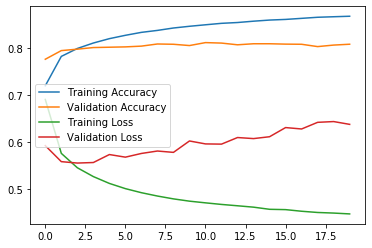

In [76]:
import matplotlib.pyplot as plt
plt.plot(history.epoch, history.history['acc'])
plt.plot(history.epoch, history.history['val_acc'])
plt.plot(history.epoch, history.history['loss'])
plt.plot(history.epoch, history.history['val_loss'])
plt.legend(['Training Accuracy', 'Validation Accuracy', 
            'Training Loss', 'Validation Loss'])

In [56]:
index=np.random.randint(0,1000)
print('random index: ',index)

result=model.predict([test_set[0][index:index+1],test_set[1][index:index+1]])
print(test[0][index:index+1])
print(test[1][index:index+1])
print('Gold: ',test[2][index:index+1])

for v1,v2,v3 in result[:][:]:
    print('Predicted: %.2f' %v1, '%.2f' %v2 ,'%.2f' %v3)


random index:  682
['A woman in red blouse is standing with small blond child in front of a small folding chalkboard .']
['a woman stands with a child']
Gold:  [[0. 0. 1.]]
Predicted: 0.00 0.02 0.98


In [0]:
# GDPR article 7
regulation=['The data subject shall have the right to withdraw his or her consent at any time.',
            'Where the child is below the age of 16 years, such processing shall be lawful only if and to the extent that consent is given or authorised by the holder of parental responsibility over the child.'
            ]

ppdata=[
  ['snapchat.com',
  'In some cases we’ll ask for consent to use your information for specific purposes.',
  'If we do, we’ll make sure you can revoke your consent in our services or through your device permissions.',
  'Even if we’re not relying on consent to use your information, we may ask you for permission to access data like contacts and location.',
  'If we need to rely on consent as a legal basis for processing your information and your country requires consent from a parent, we may require your parent’s consent before we collect and use that information.'],
  ['waze.com',
  'Your use of the Services is subject to the Terms of Use, Copyright Policy and this Privacy Policy and indicates your consent to them.',
  'Subject to your prior indication of consent (to the extent required under applicable law), we may also use the email address that you provided to send you promotional and/or marketing materials.',
  'We’ll ask for your consent before using your information for a purpose that isn’t covered in this Privacy Policy.',
  'We process your information for the purposes described in this policy, based on the following legal grounds:', 
  'With your consent We ask for your agreement to process your information for specific purposes and you have the right to withdraw your consent at any time.'],
  ['zedge.net',
  'Legal basis: We use and share this information to provide you offers and recommendations and to tailor and enhance your experience on the Websites or in the Mobile Apps when expressly agreed by you (consent) as well as to maintain the security on the Websites and in the Mobile Apps and also improve the Services on an aggregate basis (balance of interests).',
  'Legal basis: We need this information to provide the services that you request from us when you expressly agree to the processing (consent).',
  'In the event that you utilize a portion of the Services which requires your specific GPS location, we will obtain your consent before doing so.',
  'Please note that by using the Services you are consenting to the use of cookies.',
  'In the case of Zedge wanting to communicate with you through your email for other purpose than strictly tied to the service, we will ask for specific consent to do so with clear information about how to later opt-out again.',
  'Some of our advertisers provides personalised ad experience, this will be explicitly asked for consent for in the Android Mobile App(s).',
  'By clicking "CONTINUE" on Zedges signup page and acknowledging this Privacy Policy, you consent to Ogury collecting information from your device to allow it to dynamically serve more relevant promoted content to you and product support and improve its products and services.',
  'This consent applies to all applications you have installed or may install that contain Ogurys technology.',
  'You may also at any time withdraw any consent given, with future effect.']
]


In [42]:
to_seq = lambda X: pad_sequences(tokenizer.texts_to_sequences(X), maxlen=MAX_LEN)
prepare_data = lambda data: (to_seq(data[0]), to_seq(data[1]), data[2])

case = [[regulation[0]],[ppdata[0][3]],[0,0,0]]

reg_pp_test = prepare_data(case)
print(case[0])
print(case[1])
#print(reg_pp_test)
result=model.predict([reg_pp_test[0][:],reg_pp_test[1][:]])
#print(test[0][index:index+1])
#print(test[1][index:index+1])

for v1,v2,v3 in result[:][:]:
    print('Predicted: %.2f' %v1, '%.2f' %v2 ,'%.2f' %v3)

['The data subject shall have the right to withdraw his or her consent at any time.']
['Even if we’re not relying on consent to use your information, we may ask you for permission to access data like contacts and location.']
Predicted: 0.26 0.56 0.18


In [0]:
from google.colab import drive

drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/